# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# Downloading dataset
!git clone https://github.com/laxmimerit/dog-cat-full-dataset

# Moving data outside 
!mv '/content/dog-cat-full-dataset/data' '/content/data'

# Removing old directory
!rm -rf '/content/dog-cat-full-dataset'

Cloning into 'dog-cat-full-dataset'...
remote: Enumerating objects: 25027, done.
remote: Total 25027 (delta 0), reused 0 (delta 0), pack-reused 25027
Receiving objects: 100% (25027/25027), 541.62 MiB | 13.76 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Checking out files: 100% (25001/25001), done.


In [3]:
trainDS = tf.keras.preprocessing.image_dataset_from_directory('/content/data/train', image_size=(224, 224), seed=8, validation_split=0.3, subset='training')
validationDS = tf.keras.preprocessing.image_dataset_from_directory('/content/data/train', image_size=(224, 224), seed=8, validation_split=0.3, subset='validation')

testDS = tf.keras.preprocessing.image_dataset_from_directory('/content/data/test', image_size=(224, 224))

Found 20000 files belonging to 2 classes.
Using 14000 files for training.
Found 20000 files belonging to 2 classes.
Using 6000 files for validation.
Found 5000 files belonging to 2 classes.


In [4]:
# See all labels
print('Labels/Classes: ', trainDS.class_names)
# See total number of samples in training data
print('Train images count: ', len(trainDS.file_paths))

# See total number of samples in validation data
print('Validation images count: ', len(validationDS.file_paths))

# See total number of samples in testing data
print('Testing images count: ', len(testDS.file_paths))

Labels/Classes:  ['cats', 'dogs']
Train images count:  14000
Validation images count:  6000
Testing images count:  5000


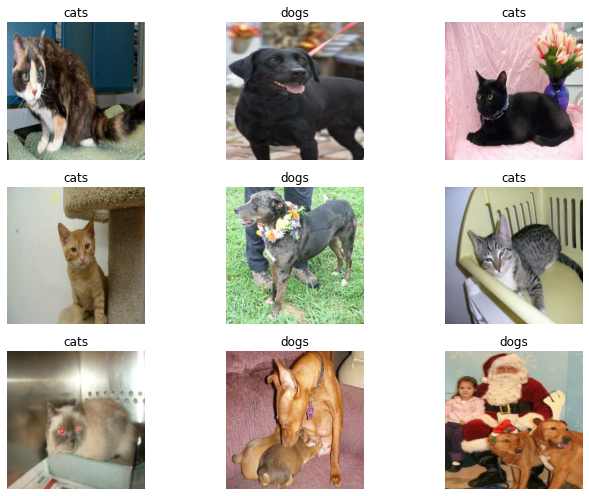

In [5]:
# Make figure to plot
plt.figure(figsize=(10,7))
# Make index count
index = 1
# Make plot data
for images, labels in trainDS.take(9):
    plt.subplot(3,3,index)
    # Make plot image
    plt.imshow(images[index-1].numpy().astype('uint8'))
    # Add label
    plt.title(trainDS.class_names[labels[index-1].numpy()])
    # Make axis  off
    plt.axis('off')

    index += 1

# Make plot tight
plt.tight_layout()
# Make show
plt.show()

In [6]:
rescaler = tf.keras.layers.Rescaling(1/(255/2), offset=-1)
filper = tf.keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=None)
rotater = tf.keras.layers.RandomRotation(0.1)
zoomer = tf.keras.layers.RandomZoom(0.05, width_factor=0.05)
contraster = tf.keras.layers.RandomContrast(0.05, seed=None)

augmentation_list = [rescaler, filper, rotater, zoomer, contraster]

for augType in augmentation_list:
    trainDS = trainDS.map(lambda x, y: (augType(x), y))
    validationDS = validationDS.map(lambda x,y: (rescaler(x), y))
    testDS = testDS.map(lambda x,y: (rescaler(x), y))

In [7]:
height,width,channels=224,224,3

In [8]:
# laod model - VGG16 with imagenet weights 
vgg16ModelBase=tf.keras.applications.VGG16(include_top=False,weights='imagenet',
                                       input_tensor=None,input_shape=(height, width, channels),
                                       pooling=None,classes=1000,
                                       classifier_activation='softmax')
# see model summary 
vgg16ModelBase.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [9]:
classNames = ['cats', 'dogs']

In [10]:
# make model 
vgg16Model=tf.keras.models.Sequential(layers=vgg16ModelBase.layers,
                                      name='VGG16_2_Class')
# add flatten layer 
vgg16Model.add(tf.keras.layers.Flatten())
# add dense map 
# add dense layer 
vgg16Model.add(tf.keras.layers.Dense(4096))
# add dropout layer 
vgg16Model.add(tf.keras.layers.Dropout(0.5))
# add dense layer 
vgg16Model.add(tf.keras.layers.Dense(4096))
# add dense layer 
vgg16Model.add(tf.keras.layers.Dense(len(classNames)))

In [11]:
# print model summary 
vgg16Model.summary()

Model: "VGG16_2_Class"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)     

In [12]:
# make model compile 
vgg16Model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1E-4,momentum=0.9,
                                                     nesterov=False,name='SGD'),
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                   metrics=['accuracy'])

In [ ]:
# add early stopping 
stopEarly=tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

# make model train 
history = vgg16Model.fit(trainDS, epochs=1000, callbacks=[stopEarly], 
                        verbose=1, 
                        validation_split=0.0, 
                        validation_data=validationDS, 
                        shuffle=True
)

Epoch 1/1000
216/438 [=============>................] - ETA: 2:51 - loss: 7.9883 - accuracy: 0.5006

In [ ]:
# make model test on testing data 
loss,accuracy=vgg16Model.evaluate(testDS)
# amek print loss and accuracy 
print('Testing accuracy:',round(accuracy*100,3),'; with loss of',loss)

In [ ]:
# laod model - Xception with imagenet weights 
vgg16ModelBase=tf.keras.applications.VGG16(include_top=False,weights='imagenet',
                                       input_tensor=None,
                                       input_shape=(height,width,channels),
                                       pooling=None,classes=1000,
                                       classifier_activation='softmax')
# see model summary 
vgg16ModelBase.summary()

In [ ]:
# laod model - Xception with imagenet weights 
xceptionModelBase=tf.keras.applications.Xception(include_top=False,weights='imagenet',
                                                 input_tensor=None,
                                                 input_shape=(height,width,channels),
                                                 pooling=None,classes=1000,
                                                 classifier_activation='softmax')
# see model summary 
xceptionModelBase.summary()

In [ ]:
# make model 
xceptionModel=tf.keras.models.Sequential(layers=xceptionModelBase,
                                         name='Xception_2_Class')
# add Global Average Pooling layer 
xceptionModel.add(tf.keras.layers.GlobalAveragePooling2D())
# add dense (output) layer 
xceptionModel.add(tf.keras.layers.Dense(len(classNames),activation='softmax'))
# print model summary 
xceptionModel.summary()

In [ ]:
# make model compile 
xceptionModel.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1E-4,
                                                        momentum=0.9,
                                                        nesterov=False,name='SGD'),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                      metrics=['accuracy'])

In [ ]:
# add early stopping 
stopEarly=tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=3,
                                           verbose=1,mode='auto',baseline=None,
                                           restore_best_weights=True)
# make model train 
historyOfXception=xceptionModel.fit(trainDS,batch_size=None,epochs=1000,verbose=1,
                                    callbacks=[stopEarly],validation_split=0.0,
                                    validation_data=validationDS,shuffle=True,)